In [1]:
import os,sys
os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.waveform import GenerateEMRIWaveform
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase
from few.utils.utility import *

import GWGen
from GWGen.WFGenerator import *

from astropy.units import yr,s
SecPerYR = yr.to(s)

M = 200000.0
mu = 1e1
a = 0.63
p0 = 26.9
e0 = 0.5
iota0 = 0.0
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.


qS = np.pi/4
phiS = 0.
qK = 1e-6
phiK = 0.
dist = 1.0
mich = False
dt = 15.0
T = 5

use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiralkwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "npoints":110,
    "dense_output":True
}

# keyword arguments for summation generator (AAKSummation)
sumkwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

FEWwfgen = Pn5AAKWaveform(inspiral_kwargs=inspiralkwargs.copy(), sum_kwargs=sumkwargs.copy(), use_gpu=use_gpu)
MYwfgen = EMRIWaveform(inspiral_kwargs=inspiralkwargs.copy(), sum_kwargs=sumkwargs.copy(), use_gpu=use_gpu)

# Trajectory Modules

Time to generate FEW traj: 0.08381223678588867
Time to generatoe My traj: 0.12637972831726074


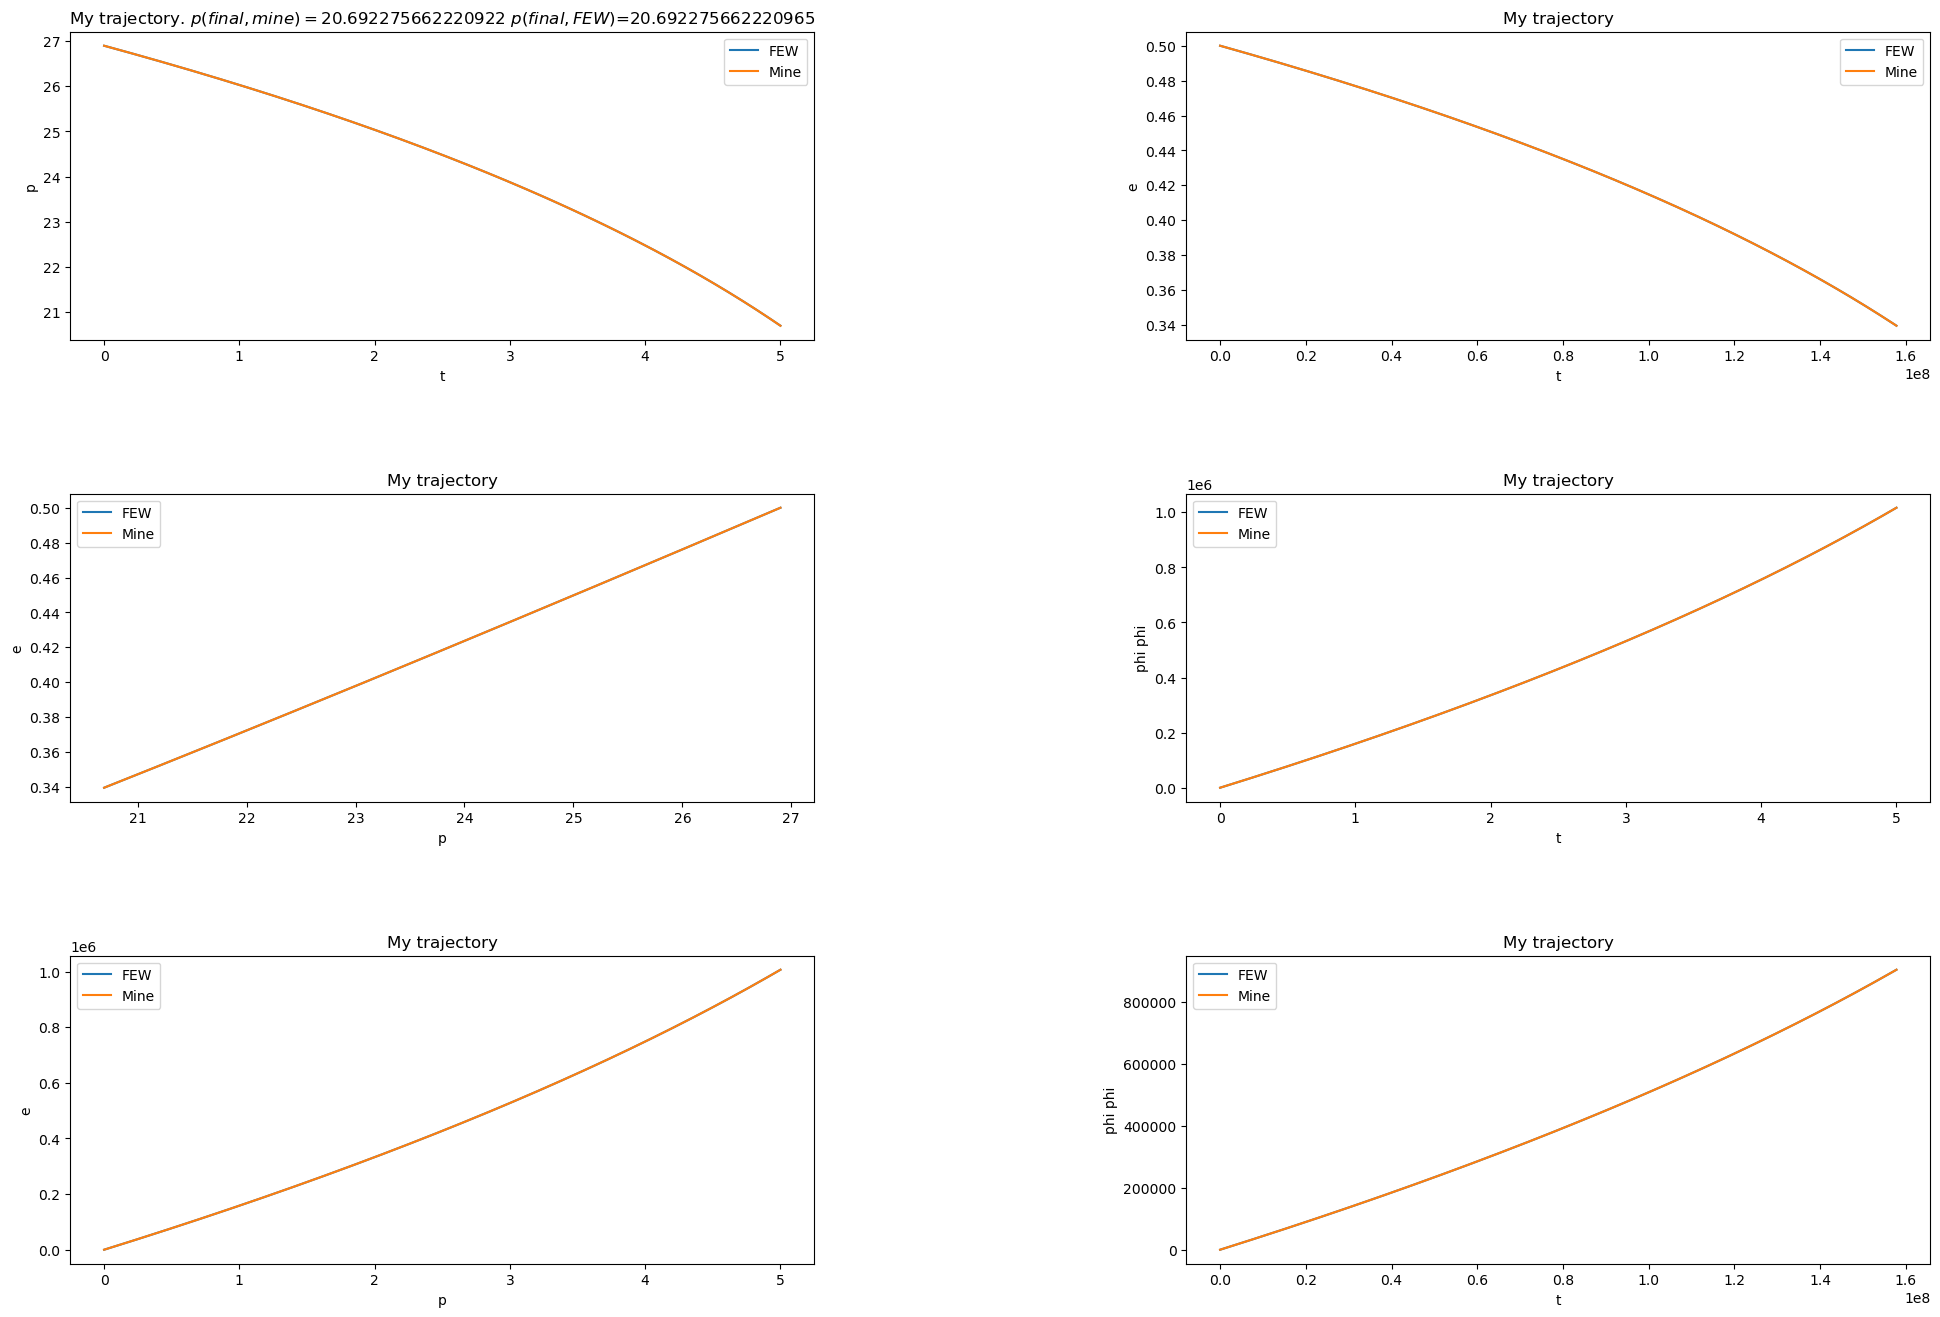

In [2]:
aa = time.time()
FEWtraj = FEWwfgen.inspiral_generator(M, mu, a, p0, e0, Y0, T=T, **inspiralkwargs)
bb = time.time()
MYtraj = MYwfgen.inspiral_generator(M, mu, a, p0, e0, Y0, T=T, **inspiralkwargs.copy())
print("Time to generate FEW traj: {0}\nTime to generatoe My traj: {1}".format(bb-aa,time.time()-bb))
tf,pf, ef, xf,phiphif,phithetaf,phirf = FEWtraj
t,p,e,x,phiphi,phitheta,phir = MYtraj

fig,axes=plt.subplots(3,2,figsize=(24,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.set_size_inches(24,16)
axes[0,0].set_title(r"My trajectory. $p(final, mine)=${0} $p(final, FEW)$={1}".format(p[-1], pf[-1]))
axes[0,0].set_ylabel("p")
axes[0,0].set_xlabel("t")
axes[0,0].plot(tf/SecPerYR,pf, label="FEW")
axes[0,0].plot(t/SecPerYR,p, label="Mine")
axes[0,0].legend()

axes[0,1].set_title("My trajectory")
axes[0,1].set_ylabel("e")
axes[0,1].set_xlabel("t")
axes[0,1].plot(tf,ef, label="FEW")
axes[0,1].plot(t,e, label="Mine")
axes[0,1].legend()

axes[1,0].set_title("My trajectory")
axes[1,0].set_ylabel("e")
axes[1,0].set_xlabel("p")
axes[1,0].plot(pf,ef, label="FEW")
axes[1,0].plot(p,e, label="Mine")
axes[1,0].legend()

axes[1,1].set_title("My trajectory")
axes[1,1].set_ylabel("phi phi")
axes[1,1].set_xlabel("t")
axes[1,1].plot(tf/SecPerYR,phiphif, label="FEW")
axes[1,1].plot(t/SecPerYR,phiphi, label="Mine")
axes[1,1].legend()

axes[2,0].set_title("My trajectory")
axes[2,0].set_ylabel("e")
axes[2,0].set_xlabel("p")
axes[2,0].plot(tf/SecPerYR,phithetaf, label="FEW")
axes[2,0].plot(t/SecPerYR,phitheta, label="Mine")
axes[2,0].legend()

axes[2,1].set_title("My trajectory")
axes[2,1].set_ylabel("phi phi")
axes[2,1].set_xlabel("t")
axes[2,1].plot(tf,phirf, label="FEW")
axes[2,1].plot(t,phir, label="Mine")
axes[2,1].legend();

# Waveform Modules

In [ ]:
FEWwf = FEWwfgen(M,mu,a,p0,e0,Y0,qS,phiS,qK,phiK,dist,mich=False, T=T, dt=dt)

In [ ]:
nmodes = int(30*e0)
if nmodes<4:
    nmodes=4
aa=time.time()
print("Generating FEW Waveform")
#FEWwf = FEWwfgen.create_waveform(FEWtraj[0], M,a,*FEWtraj[1:], mu, qS, phiS, qK, phiK, dist, nmodes,mich=mich,dt=dt,T=T)
FEWwf = FEWwfgen(M,mu,a,p0,e0,Y0,qS,phiS,qK,phiK,dist,mich=False, T=T, dt=dt)
bb=time.time()
print("Generating MY Waveform")
MYwf = MYwfgen(M,mu,a,p0,e0,Y0,qS,phiS,qK,phiK,dist,T=T)
print("Time to generate FEW wf: {0}\nTime to generatoe My wf: {1}".format(bb-aa,time.time()-bb))

if use_gpu:
    FEWwaveform = FEWwf.get()
    mywf = MYwf.get()
else:
    FEWwaveform=FEWwf
    mywf=MYwf
fig,axes = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)
fig.set_size_inches(16,8)


t = np.arange(len(mywf)) * dt
axes[0,0].set_title("My Model")
axes[0,0].plot(t, mywf.real);
xticks = axes[0,0].get_xticks()[1:-1]
axes[0,0].set_xticks(xticks, [int(i)/100 for i in (xticks*100/(60*60*24*365))]);
axes[0,0].set_xlabel("years");
axes[0,0].set_ylabel("strain");


tf =np.arange(len(FEWwaveform)) * dt;
axes[0,1].set_title("FEW Model")
axes[0,1].plot(tf, FEWwaveform.real);
xticks = axes[0,1].get_xticks()[1:-1]
axes[0,1].set_xticks(xticks, [int(i)/100 for i in (xticks*100/(60*60*24*365))]);
axes[0,1].set_xlabel("years");
axes[0,1].set_ylabel("strain");

axes[1,0].set_title("Mismatch = {0}".format(get_mismatch(FEWwaveform, mywf)))
startinginx = -100
cutoffinx = -50;
axes[1,0].plot(t[startinginx:cutoffinx], mywf.real[startinginx:cutoffinx]);
axes[1,0].plot(tf[startinginx:cutoffinx], FEWwaveform.real[startinginx:cutoffinx]);
xticks = axes[1,0].get_xticks()[1:-1]
axes[1,0].set_xticks(xticks, [int(i)/100 for i in (xticks*100/(60*60*24*31))]);
axes[1,0].set_xlabel("months");
axes[1,0].set_ylabel("strain");

fewint = spint.CubicSpline(tf,FEWwaveform.real)
axes[1,1].plot(t, fewint(t) - mywf.real);

Generating FEW Waveform
Generating MY Waveform


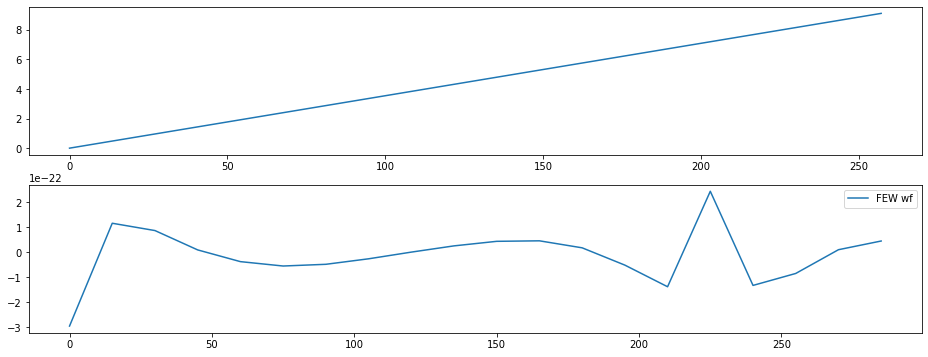

In [26]:
inxsa = 0
inxso = 20
trajinxsa = 0
trajinxso = 5
fig,ax = plt.subplots(2,1,figsize=(16,6))
ax[0].plot(FEWtraj[0][trajinxsa:trajinxso], FEWtraj[4][trajinxsa:trajinxso])
ax[1].plot(tf[inxsa:inxso], FEWwaveform.real[inxsa:inxso], label="FEW wf");
ax[1].legend();

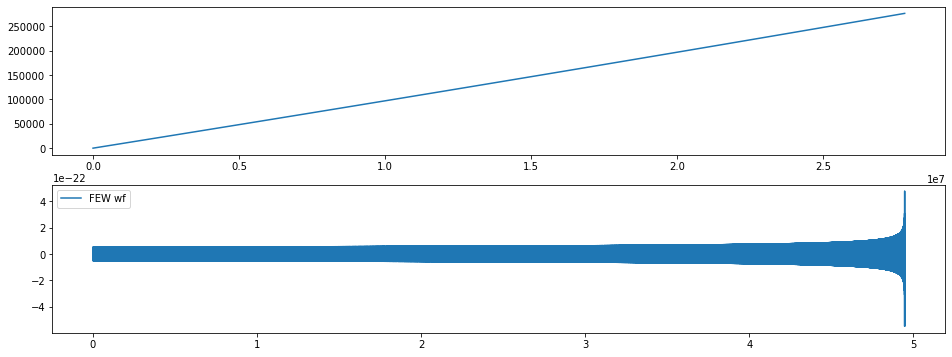

In [24]:
inxsa = 0
inxso = -1
trajinxsa = 0
trajinxso = 26
t = np.arange(len(MYwf)) * dt

fig,ax = plt.subplots(2,1,figsize=(16,6))
ax[0].plot(MYtraj[0][trajinxsa:trajinxso], MYtraj[4][trajinxsa:trajinxso])
ax[1].plot(t[inxsa:inxso]/SecPerYR, MYwf.real[inxsa:inxso], label="FEW wf");
ax[1].legend();